<a href="https://colab.research.google.com/github/flying-bear/Style-Transfer/blob/main/ArtGAN_simlified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and usefull functions

In [ ]:
from IPython.display import clear_output 
!pip install pytorch_lightning
clear_output()

In [ ]:
# Download to Colab from YaDisk
from IPython.display import clear_output 
import os, sys, json
import urllib.parse as ul
import pathlib

# Delete Colab folder with files
import shutil
#shutil.rmtree(dest, ignore_errors=True)

def download_from_yadisk(url, path):
  """Download from yadisk by link like 'https://disk.yandex.com/d/20pYBTBAKTQo-w'"""
  base_url = 'https://cloud-api.yandex.net:443/v1/disk/public/resources/download?public_key='
  pathlib.Path(path).mkdir(exist_ok=True, parents=True) 

  res = os.popen('wget -qO - {}{}'.format(base_url, url)).read()
  json_res = json.loads(res)
  filename = ul.parse_qs(ul.urlparse(json_res['href']).query)['filename'][0]
  os.system("wget '{}' -P '{}' -O '{}'".format(json_res['href'], path, filename))

  !unzip -j $filename -d $path 
  clear_output()

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np
import cv2


class RandomCropsDataset(Dataset):
  def __init__(self, path, width=512, crop=(224, 224)):
    self.files = [str(file) for file in pathlib.Path(path).iterdir()]
    self.transform = T.Compose([
      T.ToTensor(),
      T.Resize(width),
      T.RandomCrop(crop),
      T.ConvertImageDtype(torch.float),
    ])

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    try:
      image = cv2.imread(self.files[idx])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      return self.transform(image), 0
    except:
      print(f'failed to read {self.files[idx]}')
      image = cv2.imread(self.file[0])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      return self.transform(image), 0


class ContentStyleDataset(Dataset):
  """Return a random pair of (content, style)""" 
  def __init__(self, content_dataset, style_dataset, pairs_per_epoch=1000):
    self.content = content_dataset 
    self.style = style_dataset 
    self.size = pairs_per_epoch 

  def __len__(self):
    return self.size 

  def __getitem__(self, idx):
    i = np.random.randint(0, len(self.content))
    j = np.random.randint(0, len(self.style))
    content, _ = self.content[i]
    style, _ = self.style[j]
    return content, style

In [ ]:
def show_dataset(dataset, n=6):
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=n, num_workers=0, shuffle=True)
  images, classes = next(iter(data_loader))
  fig = plt.figure(figsize=(16, 8))
  if len(classes.shape) == 1:
    plt.imshow(torch.cat([images[i] for i in range(n)], 2).permute(1, 2, 0))
  else:
    first_row = torch.cat([images[i] for i in range(n)], 2)
    second_row = torch.cat([classes[i] for i in range(n)], 2) 
    plt.imshow(torch.cat([first_row, second_row], 1).permute(1, 2, 0))
  plt.show()

In [ ]:
import datetime
import pathlib
from google.colab import drive
drive.mount('/content/drive')
checkpoints_path = pathlib.Path('/content/drive/MyDrive/style-transfer/checkpoints')
checkpoints_path.mkdir(exist_ok=True, parents=True)


def get_timecoded_name(model):
  time_code = datetime.datetime.now().strftime("%y%m%d-%H%M%S") 
  model_name = model.__class__.__name__
  return model_name + '-' + time_code 


def get_file_size_mb(path):
  return path.stat().st_size / 1024 / 1024

def save_checkpoint(model, path=checkpoints_path):
  name = get_timecoded_name(model) + '.pth'
  path = pathlib.Path(path) / name
  torch.save(model.state_dict(), str(path))
  print(f'>> {str(path)} | {get_file_size_mb(path):.2f} MB')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ArtGAN: A Style-Aware Content Loss for Real-time HD Style Transfer

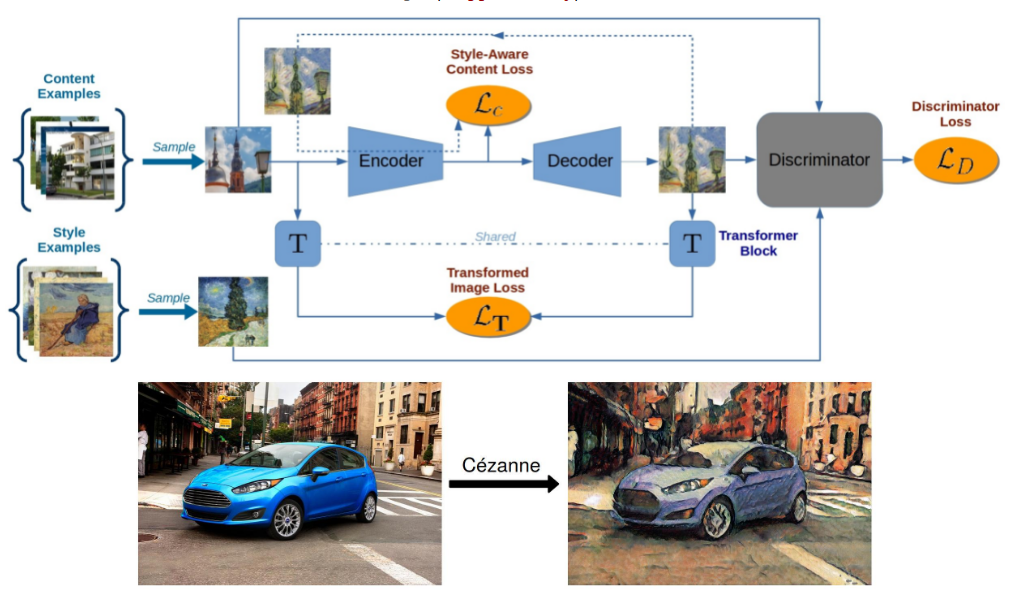

https://compvis.github.io/adaptive-style-transfer/

## Download datasets (run once) 

In [ ]:
download_from_yadisk('https://disk.yandex.ru/d/9krdOJ-FhNegSA', 'dataset/landscape')
download_from_yadisk('https://disk.yandex.ru/d/GB6EZygL6XwL4g' , 'dataset/owengent')

## View datasets

In [ ]:
dataset_landscape = RandomCropsDataset('dataset/landscape')
dataset_owengent = RandomCropsDataset('dataset/owengent')

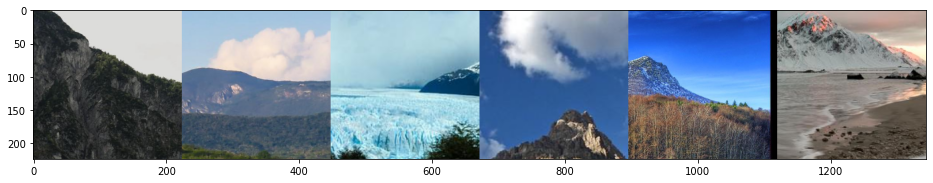

In [ ]:
show_dataset(dataset_landscape)

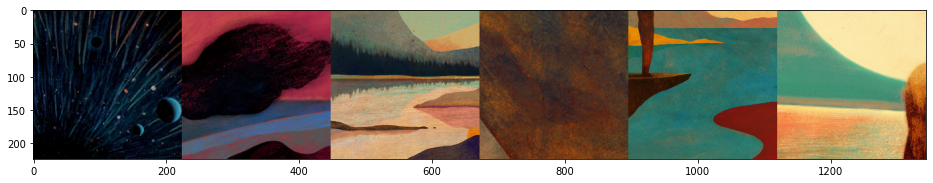

In [ ]:
show_dataset(dataset_owengent)

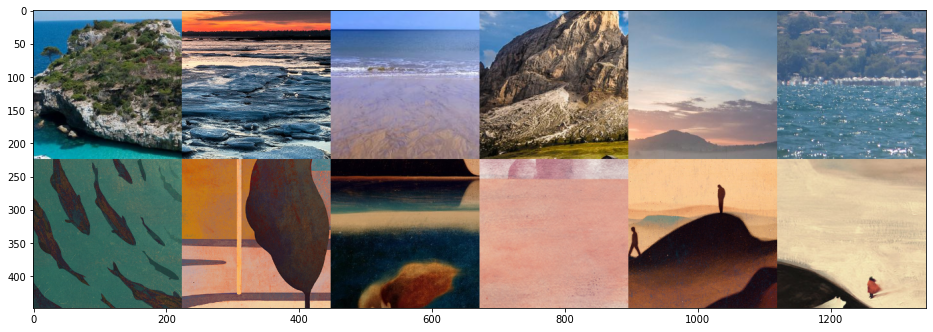

In [ ]:
dataset = ContentStyleDataset(content_dataset=dataset_landscape, 
                              style_dataset=dataset_owengent, 
                              pairs_per_epoch=1000)

show_dataset(dataset)

## Model

In [ ]:
import torch.nn as nn


class Discriminator(nn.Module):
  def __init__(self, dim=16):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(3, dim, 3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(dim),
        nn.LeakyReLU(0.1),
        nn.Conv2d(dim, dim * 2, 3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(dim * 2),
        nn.LeakyReLU(0.1),
        nn.Conv2d(dim * 2, dim * 4, 3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(dim * 4),
        nn.LeakyReLU(0.1),
        nn.Conv2d(dim * 4, dim * 8, 3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(dim * 8),
        nn.LeakyReLU(0.1),
        nn.Conv2d(dim * 8, dim * 8, 3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(dim * 8),
        nn.LeakyReLU(0.1),
        nn.Conv2d(dim * 8, dim * 8, 7, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(dim * 8),
        nn.LeakyReLU(0.1),
        nn.Conv2d(dim * 8, 1, 1, stride=1, padding=0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.layers(x).squeeze(2).squeeze(1)

In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.decoder = nn.Sequential(
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 256, (3, 3)),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 128, (3, 3)),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(128, 128, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(128, 64, (3, 3)),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(64, 64, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(64, 3, (3, 3)),
        nn.Sigmoid(),
    )

  def forward(self, x):
    return self.decoder(x)

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule

from torchvision.models import vgg19_bn as vgg 
from torch.optim import Adam


class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    model = vgg(pretrained=True)

    layers = [0, 2, 3, 5, 6, 7, 9, 10, 12, 13, 14, 16, 17, 19, 20, 22, 23, 25, 26, 27, 29]    

    self.encoder = nn.Sequential(*[model.features[i] for i in layers])
    # for param in list(self.encoder.parameters())[:10]:
    #   param.requires_grad = False

    self.decoder = Decoder() 

  def forward(self, x):
    feats = self.encoder(x)
    return self.decoder(feats), feats 

In [ ]:
gen = Generator()
print(gen)

Generator(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), s

In [ ]:
from collections import OrderedDict

class ArtGANModel(LightningModule):
  def __init__(self, lr=1e-4, discriminator_weight=1.0, decay=0.9, accuracy_threshold=0.90):
    super().__init__()
    self.save_hyperparameters()

    self.generator = Generator()
    self.discriminator = Discriminator(dim=32) 
    self.transform = nn.AvgPool2d(10, stride=1)

    self.mse_loss = nn.MSELoss()
    self.bce_loss = nn.BCELoss()
    self.sce_loss = nn.BCEWithLogitsLoss()

    self.shadow_accuracy = 0

  def update_accuracy(self, value):
    w = self.hparams.decay
    self.shadow_accuracy = self.shadow_accuracy * w + (1 - w) * value

  def adversarial_loss(self, x, y):
    return self.bce_loss(x, y) 

  def forward(self, content):
    return self.generator(content)

  def training_step(self, batch, batch_idx, optimizer_idx=0):
      content, style = batch
      n_batch = len(content)
      
      output, feats = self.generator(content)

      if optimizer_idx == 0:
        sample_imgs = output[:6]
        grid = torchvision.utils.make_grid(torch.cat((output[:6], content[:6]), 2))
        self.logger.experiment.add_image("generated images", grid, 0)

        output_feats = self.generator.encoder(output)
        content_loss = self.mse_loss(output_feats, feats)
        transform_loss = self.mse_loss(self.transform(output), self.transform(content))
  
        valid = torch.ones(content.size(0), 1)
        valid = valid.type_as(content)
        discriminator_loss = self.adversarial_loss(self.discriminator(output), valid)
        
        w = self.hparams.discriminator_weight
        loss = content_loss + transform_loss + w * discriminator_loss

        self.logger.experiment.add_scalar("generator/1-loss", loss, self.current_epoch)
        self.logger.experiment.add_scalar("generator/2-content", content_loss, self.current_epoch)
        self.logger.experiment.add_scalar("generator/3-transform", transform_loss, self.current_epoch)
        self.logger.experiment.add_scalar("generator/4-discriminator", discriminator_loss, self.current_epoch)

        if self.shadow_accuracy <= self.hparams.accuracy_threshold:
          return None

        tqdm_dict = {"g_loss": loss}
        return OrderedDict({
            "loss": loss,
            "progress_bar": tqdm_dict,
            "log": tqdm_dict
        })

      if optimizer_idx == 1:
        valid = torch.ones(n_batch, 1)
        valid = valid.type_as(content)
        fake = torch.zeros(n_batch, 1)
        fake = fake.type_as(content)

        style_pred = self.discriminator(style)
        input_pred = self.discriminator(content)
        output_pred = self.discriminator(output)

        style_loss = self.adversarial_loss(style_pred, valid)
        input_loss = self.adversarial_loss(input_pred, fake)
        output_loss = self.adversarial_loss(output_pred, fake)

        style_acc = torch.mean((style_pred > 0.5).float()).cpu().numpy()
        input_acc = torch.mean((input_pred < 0.5).float()).cpu().numpy()
        output_acc = torch.mean((output_pred < 0.5).float()).cpu().numpy()
        accuracy = np.mean([style_acc, input_acc, output_acc]) 

        self.update_accuracy(accuracy)
        self.logger.experiment.add_scalar("accuracy/1-shadow", self.shadow_accuracy, self.current_epoch)
        self.logger.experiment.add_scalar("accuracy/2-total", accuracy, self.current_epoch)
        self.logger.experiment.add_scalar("accuracy/3-style", style_acc, self.current_epoch)
        self.logger.experiment.add_scalar("accuracy/4-input", input_acc, self.current_epoch)
        self.logger.experiment.add_scalar("accuracy/5-output", output_acc, self.current_epoch)

        loss = style_loss + input_loss + output_loss

        self.logger.experiment.add_scalar("discriminator/1-loss", loss, self.current_epoch)
        self.logger.experiment.add_scalar("discriminator/2-style", style_loss, self.current_epoch)
        self.logger.experiment.add_scalar("discriminator/3-input", input_loss, self.current_epoch)
        self.logger.experiment.add_scalar("discriminator/4-output", output_loss, self.current_epoch)

        if self.shadow_accuracy > self.hparams.accuracy_threshold:
          return None

        tqdm_dict = {"d_loss": loss}
        return OrderedDict({
            "loss": loss,
            "progress_bar": tqdm_dict,
            "log": tqdm_dict
        })

  def configure_optimizers(self):
    lr = self.hparams.lr
    opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    return [opt_g, opt_d], []

In [ ]:
model = ArtGANModel(discriminator_weight=0.001)
trainer = pl.Trainer(gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
dataset = ContentStyleDataset(dataset_landscape, dataset_owengent, 16*100)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, num_workers=0, shuffle=True)

torch.save(model.state_dict(), 'tmp.pth')
model = ArtGANModel(discriminator_weight=0.04)
model.load_state_dict(torch.load('tmp.pth'))

trainer.fit(model, data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | generator     | Generator         | 7.0 M 
1 | discriminator | Discriminator     | 4.2 M 
2 | transform     | AvgPool2d         | 0     
3 | mse_loss      | MSELoss           | 0     
4 | bce_loss      | BCELoss           | 0     
5 | sce_loss      | BCEWithLogitsLoss | 0     
----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.809    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:146: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  "`training_step` returned `None`. If this was on purpose, ignore this warning..."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'log', 'progress_bar'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
 torch.save(model.state_dict(), 'tmp.pth')
 eval = ArtGANModel()
 eval.load_state_dict(torch.load('tmp.pth'))

In [ ]:
SIZE = 8 

test_content = datasets.ImageFolder('val/val/content', transform=transform)

test_content_loader = torch.utils.data.DataLoader(test_content, batch_size=SIZE, num_workers=0, shuffle=False)
test_style_loader = torch.utils.data.DataLoader(dataset_owengent, batch_size=SIZE, num_workers=0, shuffle=True)

content = next(iter(test_content_loader))[0]
style = next(iter(test_style_loader))[0]

plot = np.zeros((3, SIZE, 224, 224, 3))

plot[0, 0] = 1
for i in range(SIZE):
  plot[1, i] = content[i].permute(1, 2, 0).numpy()
  plot[0, i] = style[i].permute(1, 2, 0).numpy()

model.cuda()
for i in range(1):
  images = model(content.cuda())[0].cpu().detach()
  for k in range(SIZE):
    plot[2, k] = images[k].permute(1, 2, 0).numpy()

fig = plt.figure(figsize=(24, 24))

size_w = (SIZE) * 224
size_h = 3 * 224
plt.imshow(np.transpose(plot, (0, 2, 1, 3, 4)).reshape((size_h, size_w, 3)))

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# SAVE

- add logs and learn `tensorboard`
- add accuracies to manage disc/gen training process as in the paper

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T
from torchvision.io import read_image
from torchvision.utils import save_image

plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)


def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20, 20))
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
import uuid
from google.colab import drive
from torchvision.io import read_image
from torchvision.utils import save_image
drive.mount('/content/drive')

def evaluate(model, path='exms', output_path='/content/drive/MyDrive/style-transfer/examples'):
  prefix = get_timecoded_name(model)
  output_path = pathlib.Path(output_path) / prefix
  output_path.mkdir(exist_ok=True, parents=True)
  save_checkpoint(model, path=output_path)

  
  notebook_copy = str(output_path / 'style-transfer.ipynb')
  notebook_init = '/content/drive/MyDrive/style-transfer/
  !cp style-transfer.ipynb $notebook_copy
  model.eval()
  model.cuda()
  for file in pathlib.Path('exms').iterdir():
    try:
      image = read_image(str(file)).float() / 255.
      stylized_image = model(image.unsqueeze(0).cuda())[0][0]
      name = str(uuid.uuid4())[:8] + '.png'
      fp = str(output_path / name)
      save_image(torch.cat((image, T.Resize(image.shape[1:])(stylized_image.cpu())), 2), fp)
      print(f'>> {fp}')
    except:
      print(f'fail to read file: {file}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# model = ArtGANModel()
# model.load_state_dict(torch.load('/content/drive/MyDrive/style-transfer/examples/ArtGANModel-220122-093404/ArtGANModel-220122-093404.pth'))
evaluate(model)

>> /content/drive/MyDrive/style-transfer/examples/ArtGANModel-220124-170831/ArtGANModel-220124-170831.pth | 42.77 MB
cp: cannot stat 'style-transfer.ipynb': No such file or directory
>> /content/drive/MyDrive/style-transfer/examples/ArtGANModel-220124-170831/af1643ba.png
>> /content/drive/MyDrive/style-transfer/examples/ArtGANModel-220124-170831/79bcc5f9.png
>> /content/drive/MyDrive/style-transfer/examples/ArtGANModel-220124-170831/ad739fc4.png
>> /content/drive/MyDrive/style-transfer/examples/ArtGANModel-220124-170831/1287fadf.png
>> /content/drive/MyDrive/style-transfer/examples/ArtGANModel-220124-170831/410de9a9.png
fail to read file: exms/photo_2022-01-21_17-46-59.jpg
>> /content/drive/MyDrive/style-transfer/examples/ArtGANModel-220124-170831/733a6abb.png
>> /content/drive/MyDrive/style-transfer/examples/ArtGANModel-220124-170831/43afadad.png
>> /content/drive/MyDrive/style-transfer/examples/ArtGANModel-220124-170831/19429c70.png
>> /content/drive/MyDrive/style-transfer/examples/A